# Логистик регресс ашиглан орлогын түвшнийг илрүүлэх

## Өгөгдөл

**Эх сурвалж:** Income Dataset
https://www.kaggle.com/datasets/mastmustu/income

**Зорилго:** Ажил, боловсрол, хүн ам зүйн мэдээллийг ашиглан хувь хүний жилийн орлого 50,000 ам.доллараас дээш эсэхийг урьдчилан таамаглах.

**Өгөгдлийн тухай:**
- **Нийт түүврийн хэмжээ:** 43957
- **Сургалтын өгөгдөл:** 35165 түүврүүд (80%)
- **Баталгаажуулалтын өгөгдөл:** 8792 түүврүүд (20%)

**Классуудын тархалт:**
- **≤$50K:** ~76% (олонх класс)
- **>$50K:** ~24% (цөөнх класс)

Өгөгдөл маань классуудын хувьд тэнцвэргүй байна. Үргэлж 0 гэж таахад л accuracy нь 76% гэж гарч ирнэ. Бид 2 классыг хоёуланг нь оновтойгоор авч үздэг логистик регресс загвар гаргах ёстой болоод байна.

**Хувьсагчид (нийт 9):**
- **Тоон (5):** age, educational-num, capital-gain, capital-loss, hours-per-week
- **Чанарын (4):** education, occupation, relationship, gender. Гэхдээ OneHotEncoder ашигласны дараа хувьсагч бүр дахиад задарна.

**Зорилтот хувьсагч:** `income_>50K` (0 = ≤50K, 1 = >50K)

In [57]:
import sys
sys.path.append('../src')

import pickle
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

## Өгөгдөл болон моделийг ачаалах

In [58]:
val_df = pd.read_csv('../data/val_split.csv')
X_val = val_df.drop(columns=['income_>50K'])
y_val = val_df['income_>50K']

model_path = Path('../models/logreg_pipeline.pkl')
with open(model_path, 'rb') as f:
    model = pickle.load(f)

preprocessor = model.named_steps['preprocess']
logreg = model.named_steps['logreg']

X_val_processed = preprocessor.transform(X_val)
y_pred = logreg.predict(X_val_processed)
y_proba = logreg.predict_proba(X_val_processed)[:, 1]

## Сургалт

Бидний хэрэгжүүлэлт нь градиент бууруулалт (gradient descent) ашигладаг. Дараах график нь сургалтын явцад алдаа болон сургалтын хурд хэрхэн өөрчлөгдөж байгааг харж болно.

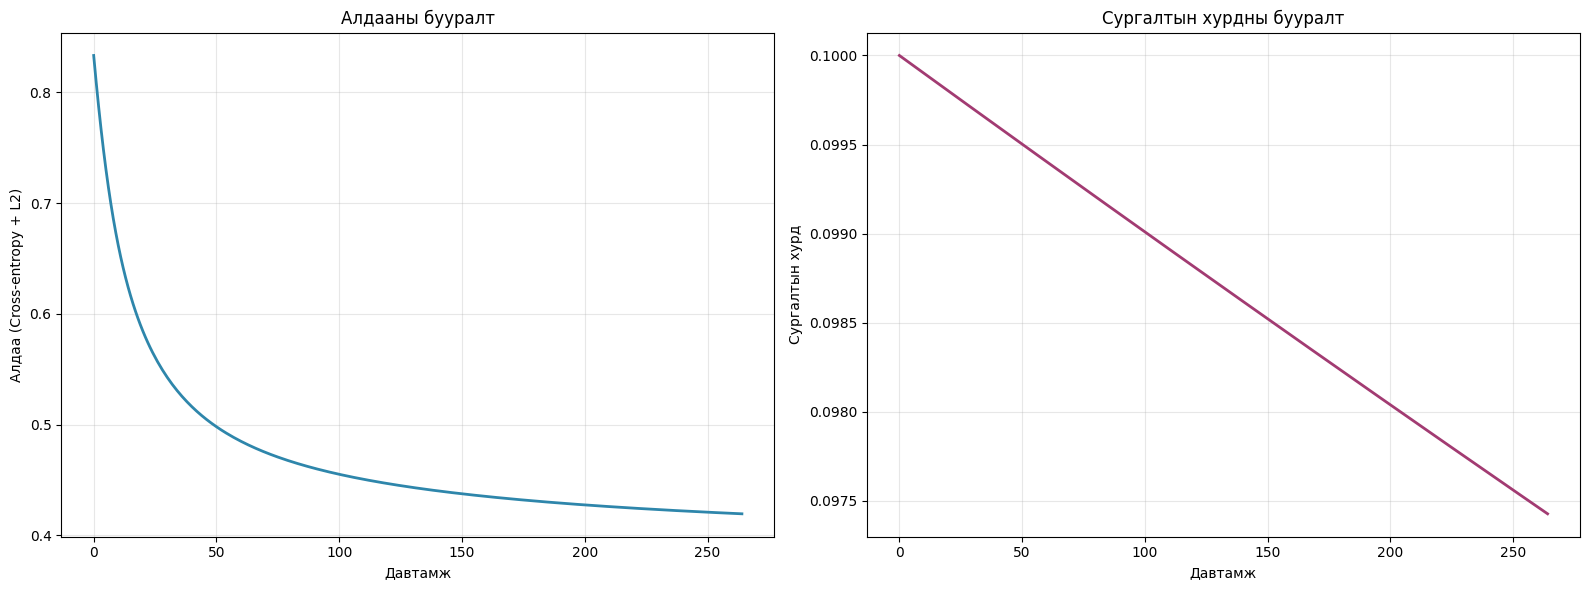

Анхны алдаа: 0.8331
Сургалтын дараах алдаа: 0.4195
Нийт давтамж: 265
Алдааны бууралт: 49.64%


In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(logreg.losses, linewidth=2, color='#2E86AB')
ax1.set_xlabel('Давтамж'); ax1.set_ylabel('Алдаа (Cross-entropy + L2)')
ax1.set_title('Алдааны бууралт'); ax1.grid(alpha=0.3)
iterations = range(len(logreg.losses))
learning_rates = [logreg.initial_lr / (1 + logreg.lr_decay * i) for i in iterations]
ax2.plot(learning_rates, linewidth=2, color='#A23B72')
ax2.set_xlabel('Давтамж'); ax2.set_ylabel('Сургалтын хурд')
ax2.set_title('Сургалтын хурдны бууралт'); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()
print(f"Анхны алдаа: {logreg.losses[0]:.4f}")
print(f"Сургалтын дараах алдаа: {logreg.losses[-1]:.4f}")
print(f"Нийт давтамж: {len(logreg.losses)}")
print(f"Алдааны бууралт: {((logreg.losses[0] - logreg.losses[-1]) / logreg.losses[0] * 100):.2f}%")

## Загварын гүйцэтгэлийн үзүүлэлтүүд

In [60]:
metrics = {
    'Accuracy':  accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall':    recall_score(y_val, y_pred),
    'F1 score':  f1_score(y_val, y_pred),
    'Threshold': float(logreg.threshold)
}
pd.DataFrame(list(metrics.items()), columns=['Үзүүлэлт','Оноо'])

,Үзүүлэлт,Оноо
0,Accuracy,0.809827
1,Precision,0.574176
2,Recall,0.794677
3,F1 score,0.666667
4,Threshold,0.540000


## Confusion matrix

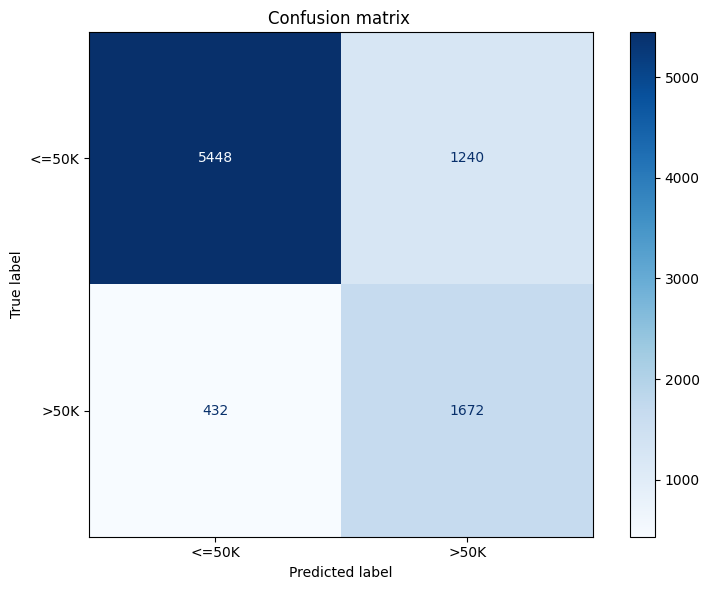

In [61]:
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K','>50K'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion matrix '); plt.tight_layout(); plt.show()

## Онцлогуудын жин

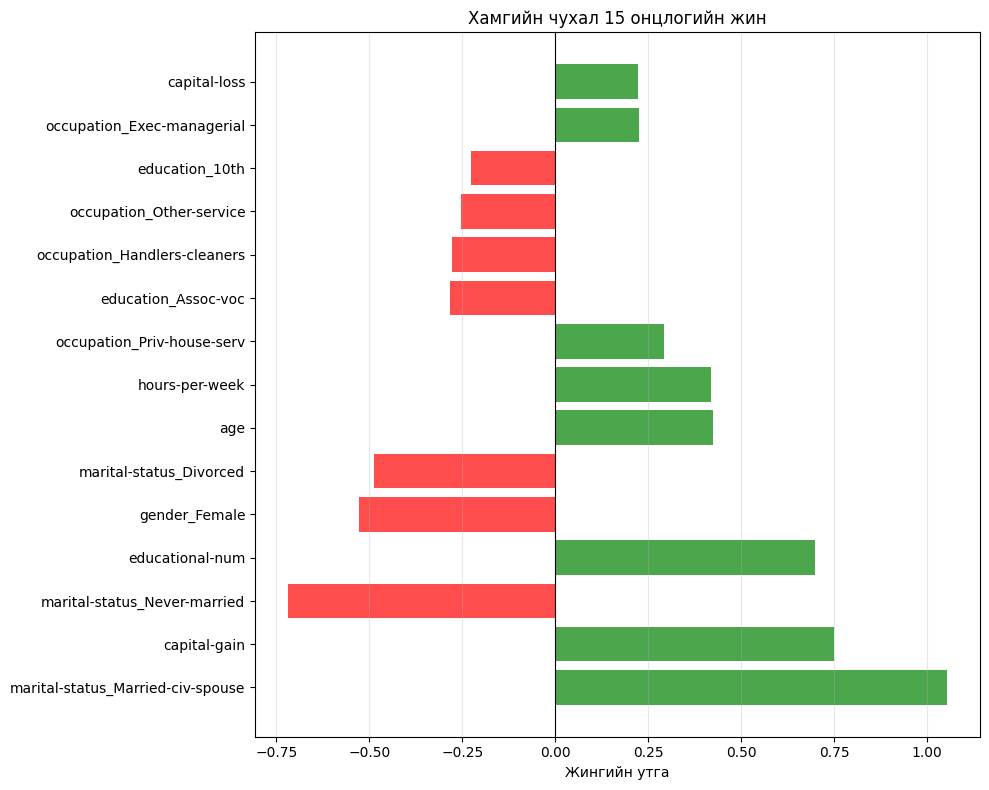

,Онцлог,Жин
0,marital-status_Married-civ-spouse,1.053197
1,capital-gain,0.749859
2,marital-status_Never-married,-0.718136
3,educational-num,0.698519
4,gender_Female,-0.527779
5,marital-status_Divorced,-0.488251
6,age,0.425019
7,hours-per-week,0.418314
8,occupation_Priv-house-serv,0.292166
9,education_Assoc-voc,-0.283291


In [62]:
top_n = 15
num_features = preprocessor.transformers_[0][2]
cat_cols = preprocessor.transformers_[1][2]
encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_feature_names = encoder.get_feature_names_out(cat_cols)
feature_names = list(num_features) + list(cat_feature_names)
coefs = logreg.weights.ravel()
importance_df = pd.DataFrame({'Онцлог': feature_names, 'Жин': coefs})
importance_df = importance_df.reindex(importance_df['Жин'].abs().sort_values(ascending=False).index).reset_index(drop=True)
top_features = importance_df.head(top_n)
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['Жин']]
ax.barh(range(len(top_features)), top_features['Жин'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features))); ax.set_yticklabels(top_features['Онцлог'])
ax.set_xlabel('Жингийн утга'); ax.set_title(f'Хамгийн чухал {top_n} онцлогийн жин')
ax.axvline(x=0, color='black', linewidth=0.8); ax.grid(axis='x', alpha=0.3)
plt.tight_layout(); plt.show(); display(top_features)

**Ногоон шугам**: Класс 1-тэй илүү корреляцитай

**Улаан шугам**: Класс 0-тэй илүү корреляцитай

## Сигмоид функц ба хязгаар

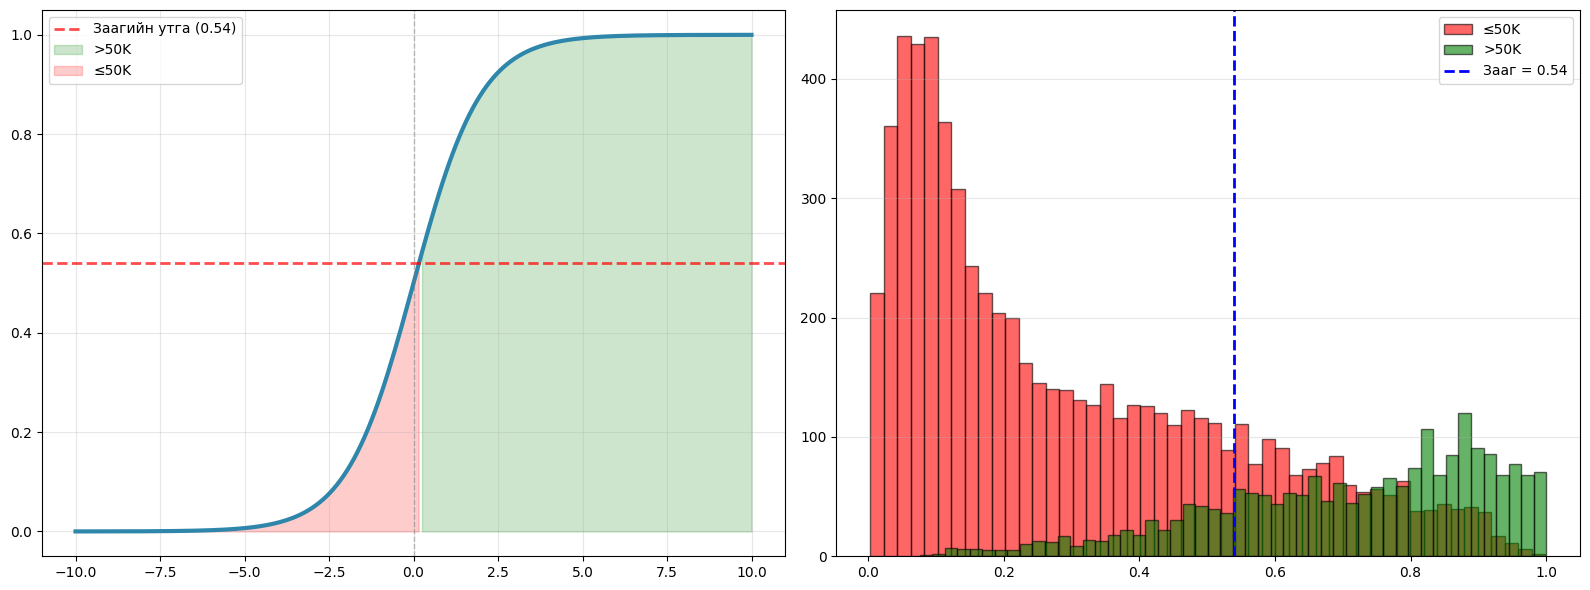

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
z_range = np.linspace(-10, 10, 200)
sigmoid_values = logreg.sigmoid(z_range)
ax1.plot(z_range, sigmoid_values, linewidth=3, color='#2E86AB')
ax1.axhline(y=logreg.threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Заагийн утга ({logreg.threshold:.2f})')
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values >= logreg.threshold), alpha=0.2, color='green', label='>50K')
ax1.fill_between(z_range, 0, sigmoid_values, where=(sigmoid_values < logreg.threshold), alpha=0.2, color='red', label='≤50K')
ax1.set_ylim([-0.05, 1.05]); ax1.legend(); ax1.grid(alpha=0.3)
proba_class0 = y_proba[y_val == 0]
proba_class1 = y_proba[y_val == 1]
ax2.hist(proba_class0, bins=50, alpha=0.6, color='red', label='≤50K', edgecolor='black')
ax2.hist(proba_class1, bins=50, alpha=0.6, color='green', label='>50K', edgecolor='black')
ax2.axvline(x=logreg.threshold, color='blue', linestyle='--', linewidth=2, label=f'Зааг = {logreg.threshold:.2f}')
ax2.legend(); ax2.grid(alpha=0.3, axis='y')
plt.tight_layout(); plt.show()

## Заагийн утгын оновчлол

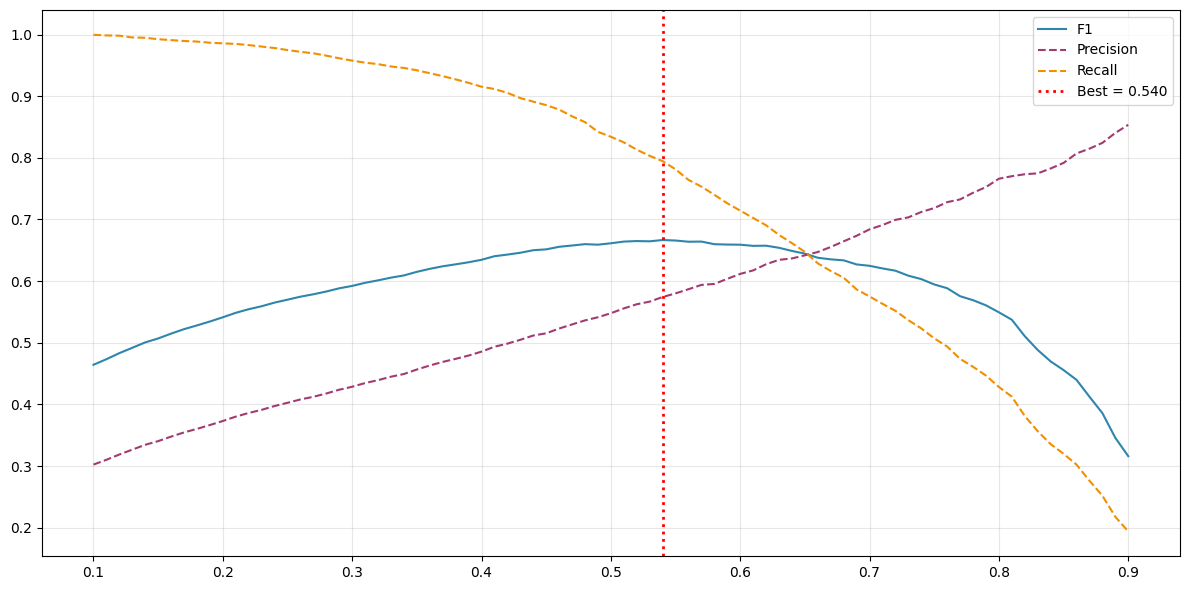

In [64]:
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []; precision_scores = []; recall_scores = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_t))
    precision_scores.append(precision_score(y_val, y_pred_t))
    recall_scores.append(recall_score(y_val, y_pred_t))
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds, f1_scores, label='F1', color='#2E86AB')
ax.plot(thresholds, precision_scores, label='Precision', color='#A23B72', linestyle='--')
ax.plot(thresholds, recall_scores, label='Recall', color='#F18F01', linestyle='--')
ax.axvline(x=optimal_threshold, color='red', linestyle=':', linewidth=2, label=f'Best = {optimal_threshold:.3f}')
ax.legend(); ax.grid(alpha=0.3); plt.tight_layout(); plt.show()